In [2]:
import pandas as pd


def load_and_prepare_data(file_path, column_names):
    df = pd.read_csv(file_path, skiprows=6)
    df.columns = column_names  
    df[column_names[1]] = df[column_names[1]].str.replace('\xa0', '')  
    df[column_names[1]] = df[column_names[1]].str.replace('Â', '')  
    df[column_names[1]] = pd.to_numeric(df[column_names[1]])  
    df[column_names[0]] = pd.to_datetime(df[column_names[0]], format='%d.%m.%Y')
    return df


users_df = load_and_prepare_data('user.csv', ['date', 'users'])
sessions_df = load_and_prepare_data('sessions.csv', ['date', 'sessions'])
pageviews_df = load_and_prepare_data('pageview.csv', ['date', 'pageviews'])

In [3]:
print("Users DataFrame:")
print(users_df.head(), "\n")

print("Sessions DataFrame:")
print(sessions_df.head(), "\n")

print("Pageviews DataFrame:")
print(pageviews_df.head())

Users DataFrame:
        date  users
0 2022-10-01   1445
1 2022-10-02   1494
2 2022-10-03   2707
3 2022-10-04   2809
4 2022-10-05   2680 

Sessions DataFrame:
        date  sessions
0 2022-10-01      1573
1 2022-10-02      1624
2 2022-10-03      2984
3 2022-10-04      3086
4 2022-10-05      3015 

Pageviews DataFrame:
        date  pageviews
0 2022-10-01       7567
1 2022-10-02       7457
2 2022-10-03      15311
3 2022-10-04      15463
4 2022-10-05      15026


In [49]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from scipy import stats


def detect_anomalies(df, column_name):
    anomalies = {}

    # One-Class SVM
    svm = OneClassSVM(nu=0.3, kernel='rbf', gamma=0.01) 
    df['svm_anomaly'] = svm.fit_predict(df[[column_name]])
    anomalies['One-Class SVM'] = df[df['svm_anomaly'] == -1]

    # Z-score
    df['z_score'] = np.abs(stats.zscore(df[column_name]))
    df['z_anomaly'] = df['z_score'] > 3
    anomalies['Z-score'] = df[df['z_anomaly']]

    # Moving average
    df['moving_average'] = df[column_name].rolling(window=7).mean()
    df['ma_std'] = df[column_name].rolling(window=7).std()
    df['ma_anomaly'] = np.abs(df[column_name] - df['moving_average']) > (2 * df['ma_std'])
    anomalies['Moving Average'] = df[df['ma_anomaly']]

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.01)
    df['iso_forest_anomaly'] = iso_forest.fit_predict(df[[column_name]])
    anomalies['Isolation Forest'] = df[df['iso_forest_anomaly'] == -1]

    return anomalies


users_anomalies = detect_anomalies(users_df, 'users')
sessions_anomalies = detect_anomalies(sessions_df, 'sessions')
pageviews_anomalies = detect_anomalies(pageviews_df, 'pageviews')

In [50]:
for method, anomalies in users_anomalies.items():
    print(f"Users - {method} anomalies:")
    print(anomalies[['date', 'users']])
    print("\n")

Users - One-Class SVM anomalies:
          date   users
1   2022-10-02    1494
13  2022-10-14    2651
15  2022-10-16    1683
16  2022-10-17    3036
29  2022-10-30    1494
..         ...     ...
263 2023-06-21    4824
267 2023-06-25    2097
270 2023-06-28    2732
271 2023-06-29    2934
273        NaT  633861

[97 rows x 2 columns]


Users - Z-score anomalies:
    date   users
273  NaT  633861


Users - Moving Average anomalies:
          date   users
58  2022-11-28    5176
67  2022-12-07    8161
273        NaT  633861


Users - Isolation Forest anomalies:
          date   users
58  2022-11-28    5176
67  2022-12-07    8161
273        NaT  633861




In [51]:
for method, anomalies in sessions_anomalies.items():
    print(f"Sessions - {method} anomalies:")
    print(anomalies[['date', 'sessions']])
    print("\n")

Sessions - One-Class SVM anomalies:
          date  sessions
3   2022-10-04      3086
5   2022-10-06      3352
10  2022-10-11      3187
12  2022-10-13      3376
13  2022-10-14      2944
..         ...       ...
257 2023-06-15      2566
260 2023-06-18      3197
261 2023-06-19      2626
269 2023-06-27      3831
272 2023-06-30      3242

[100 rows x 2 columns]


Sessions - Z-score anomalies:
    date  sessions
273  NaT    700939


Sessions - Moving Average anomalies:
          date  sessions
58  2022-11-28      5971
67  2022-12-07      9068
273        NaT    700939


Sessions - Isolation Forest anomalies:
          date  sessions
58  2022-11-28      5971
67  2022-12-07      9068
273        NaT    700939




In [52]:
for method, anomalies in pageviews_anomalies.items():
    print(f"Pageviews - {method} anomalies:")
    print(anomalies[['date', 'pageviews']])
    print("\n")

Pageviews - One-Class SVM anomalies:
          date  pageviews
0   2022-10-01       7567
4   2022-10-05      15026
6   2022-10-07      13908
7   2022-10-08       7418
8   2022-10-09       7728
..         ...        ...
266 2023-06-24       6715
268 2023-06-26       9705
269 2023-06-27      15018
271 2023-06-29      12460
272 2023-06-30      10502

[130 rows x 2 columns]


Pageviews - Z-score anomalies:
    date  pageviews
273  NaT    3010883


Pageviews - Moving Average anomalies:
          date  pageviews
58  2022-11-28      46763
67  2022-12-07      48924
273        NaT    3010883


Pageviews - Isolation Forest anomalies:
          date  pageviews
58  2022-11-28      46763
67  2022-12-07      48924
273        NaT    3010883




In [53]:
import matplotlib.pyplot as plt
def plot_anomalies(normal_data, anomalies, column_name, title):
    plt.figure(figsize=(12, 6))
    plt.plot(normal_data['date'], normal_data[column_name], label='Normal Data')
    plt.scatter(anomalies['date'], anomalies[column_name], color='red', label='Anomalies')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

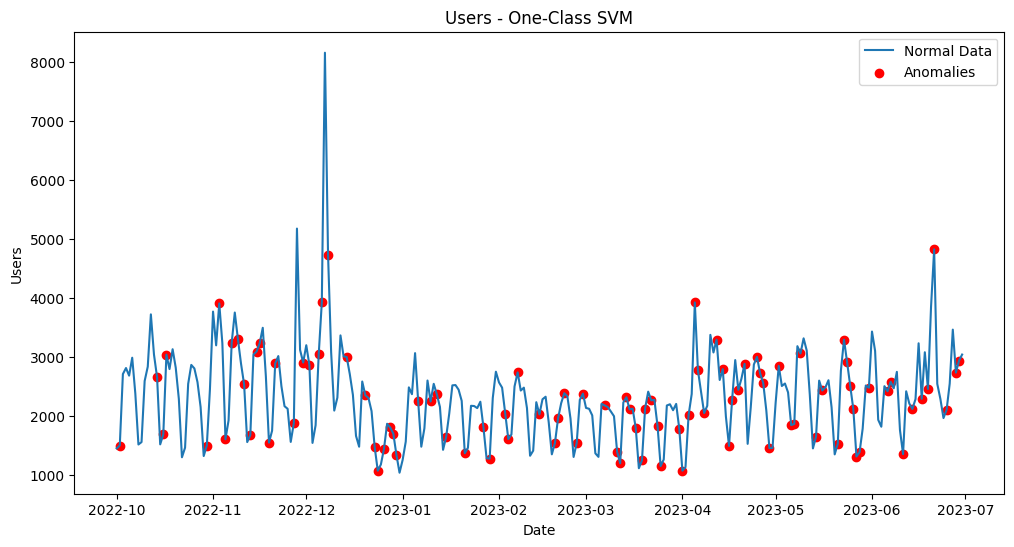

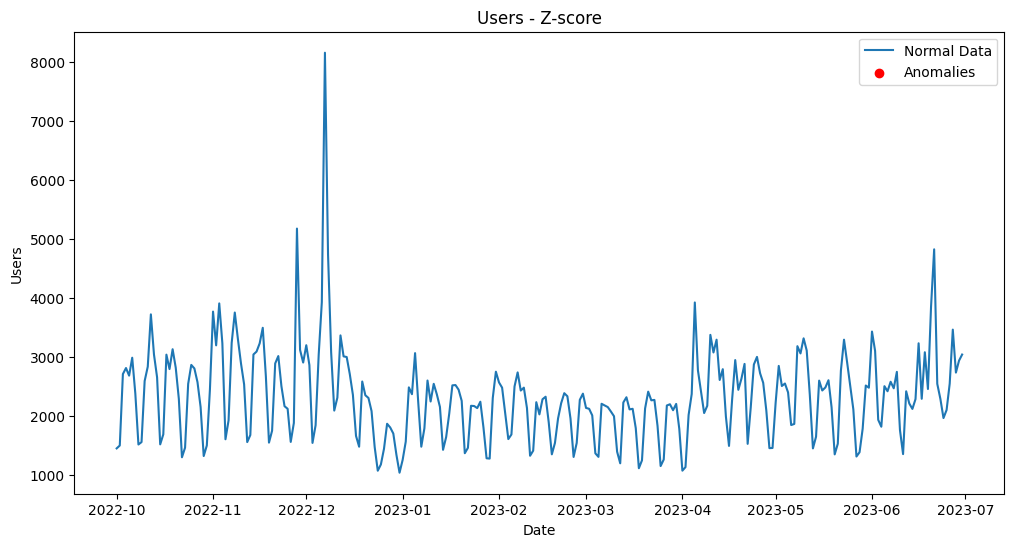

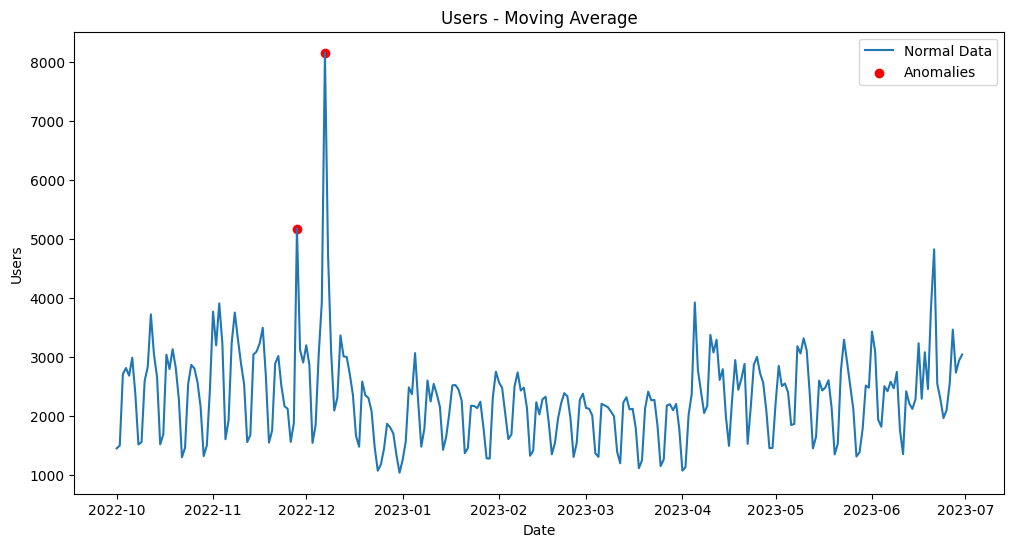

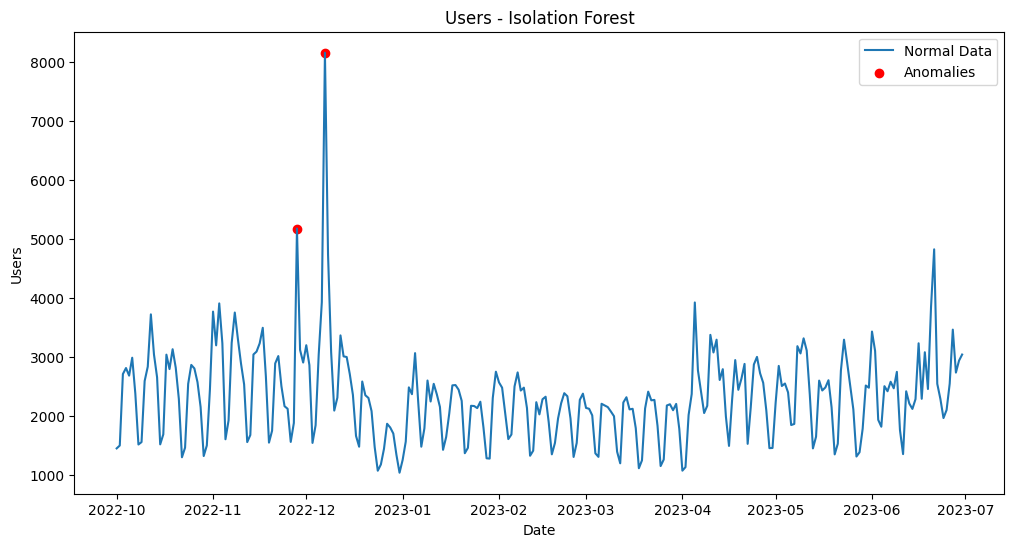

In [54]:
for method, anomalies in users_anomalies.items():
    plot_anomalies(users_df, anomalies, 'users', f"Users - {method}")

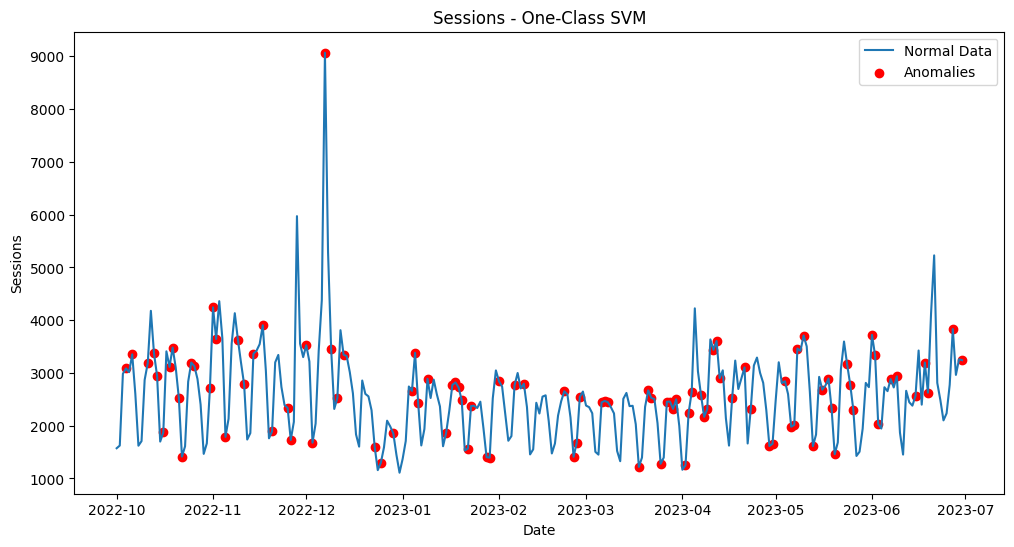

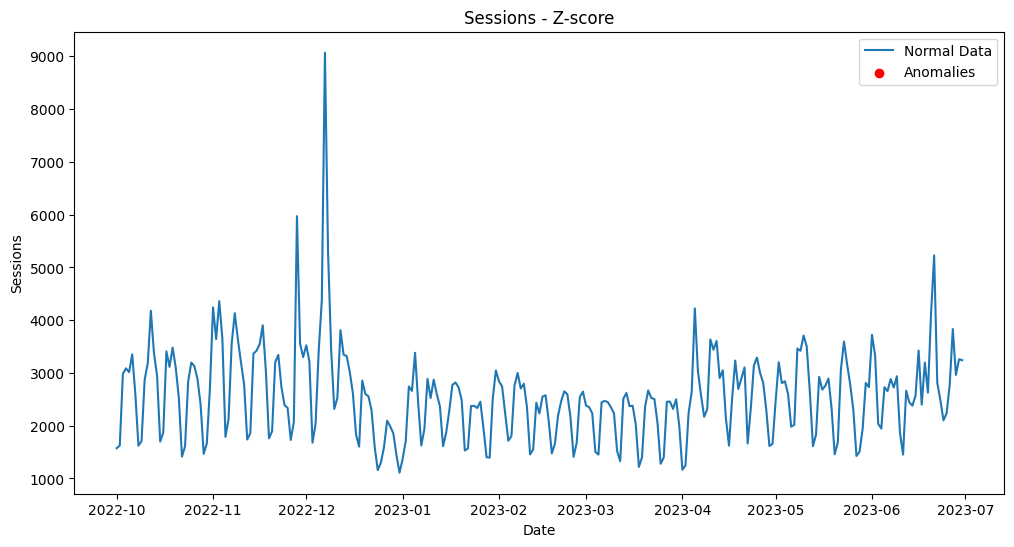

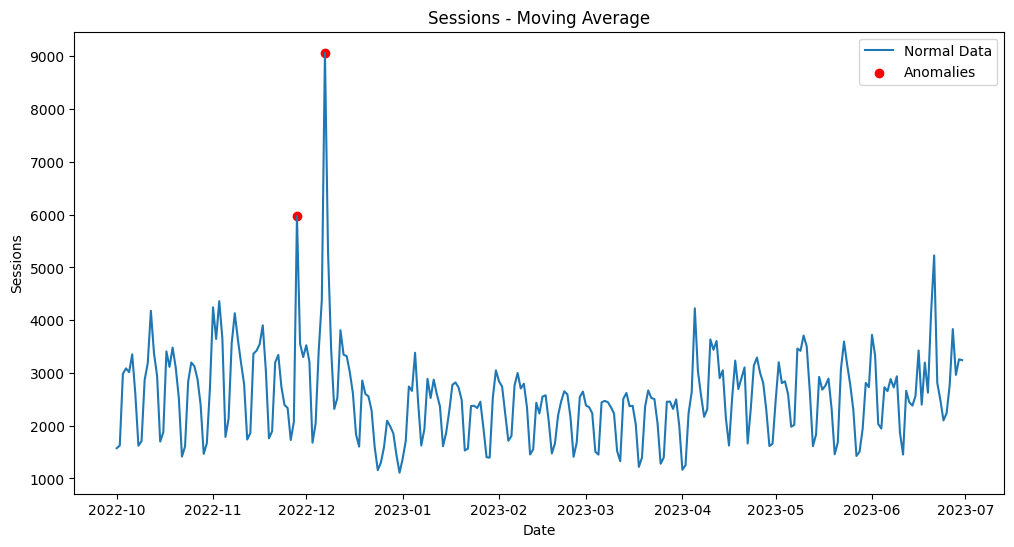

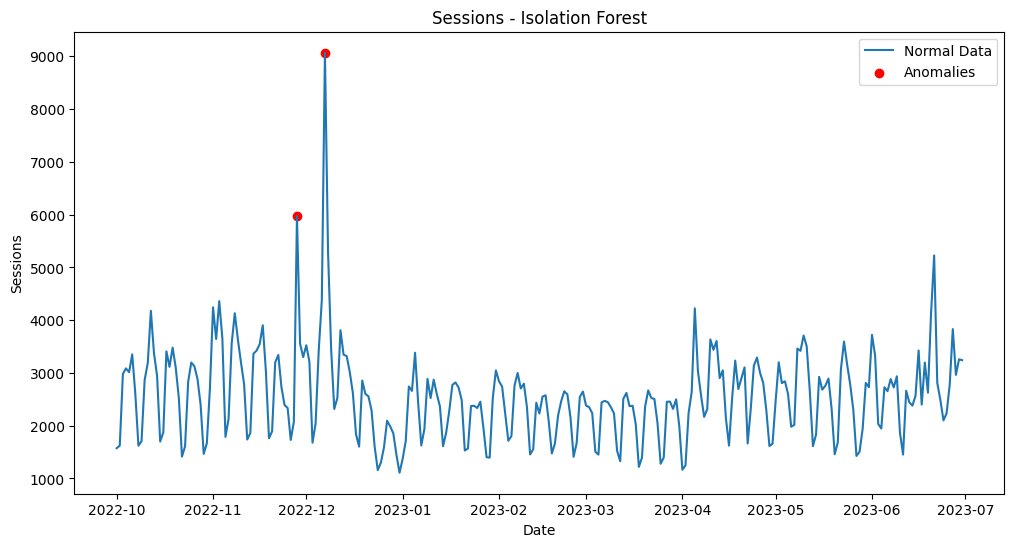

In [55]:
for method, anomalies in sessions_anomalies.items():
    plot_anomalies(sessions_df, anomalies, 'sessions', f"Sessions - {method}")

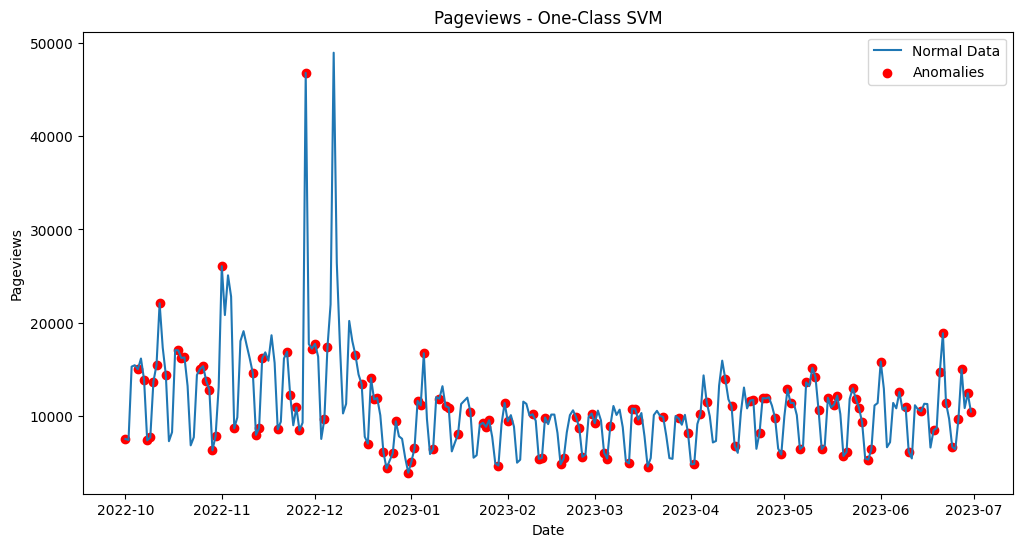

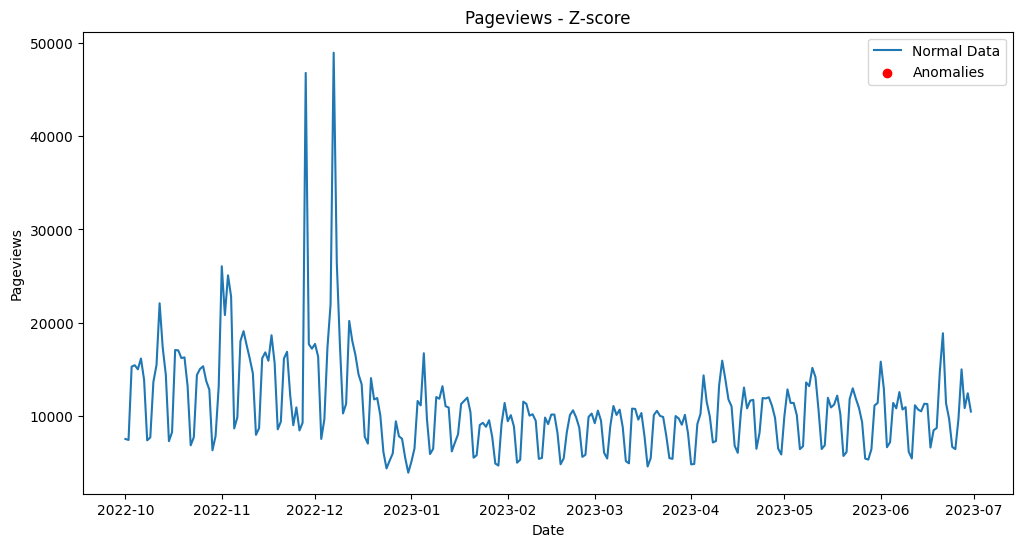

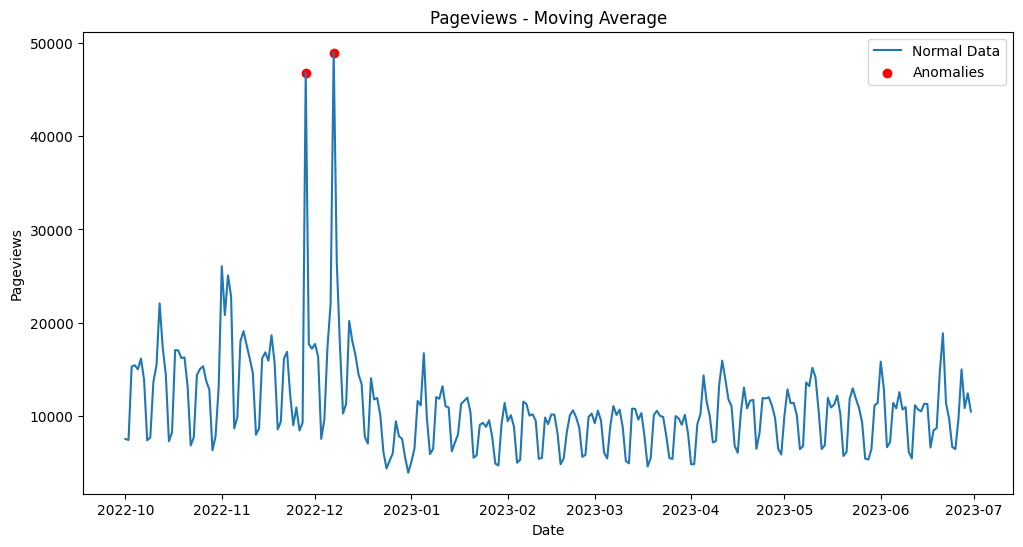

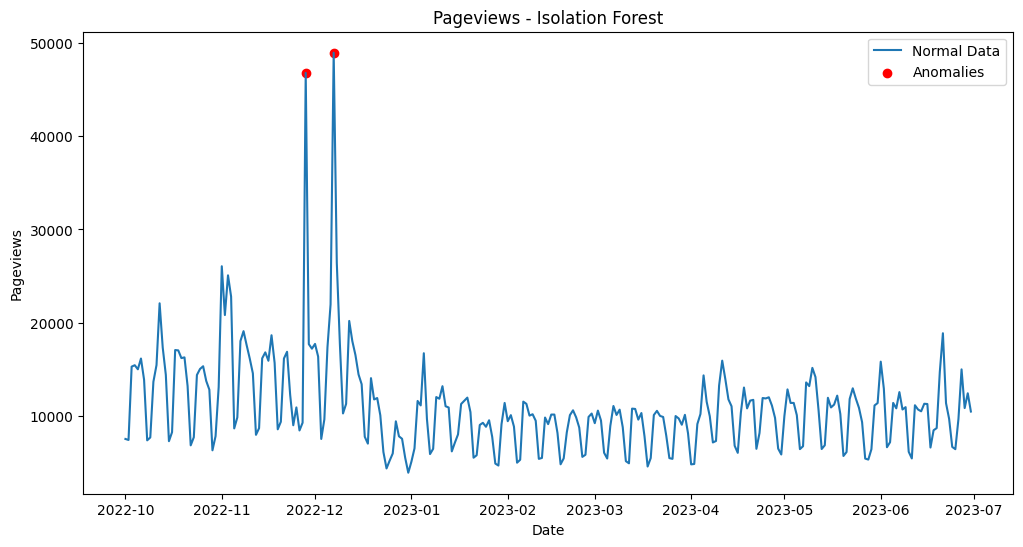

In [56]:
for method, anomalies in pageviews_anomalies.items():
    plot_anomalies(pageviews_df, anomalies, 'pageviews', f"Pageviews - {method}")